# Working pipeline

In [2]:
##Pure python
from multiprocessing import Pool, cpu_count
import subprocess
import pandas as pd
import numpy as np
from math import  exp
import seaborn as sns

#import os moduls
import os

## Bioconda
import pybedtools
import pyBigWig
import pysam

#Biopython
from Bio.SeqUtils import GC
%matplotlib inline

/home/kipkurui/anaconda2/envs/dream_challenge/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import matplotlib.pyplot as plt

#### Determine number of Cores for parallel execution

In [4]:
num_partitions = cpu_count()

num_cores = cpu_count()

In [5]:
def energyscore(pwm_dictionary, seq):
    """
    Score sequences using the beeml energy scoring approach.

    Borrowed greatly from the work of Zhao and Stormo

    P(Si)=1/(1+e^Ei-u)

    Ei=sumsum(Si(b,k)e(b,k))

    Previous approaches seem to be using the the minimum sum of the
    energy contribution of each of the bases of a specific region.

    This is currently showing some promise but further testing is
    needed to ensure that I have a robust algorithm.
    """
    
    energy_list = []
    pwm_length = len(pwm_dictionary["A"])
    pwm_dictionary_rc = rc_pwm(pwm_dictionary, pwm_length)
    for i in range(len(seq) - 1):
        energy = 0
        energy_rc = 0
        for j in range(pwm_length - 1):
            if (j + i) >= len(seq):
                energy += 0.25
                energy_rc += 0.25
            else:
                energy += pwm_dictionary[seq[j + i]][j]
                energy_rc += pwm_dictionary_rc[seq[j + i]][j]

            energy_list.append(1 / (1 + (exp(energy))))
            energy_list.append(1 / (1 + (exp(energy_rc))))
    energy_score = min(energy_list)
    return energy_score

def gomeroccupancyscore(pwm_dictionary, seq):
    """
    Takes as input a PWM dictionary, and a sequences and
    computes the gomer score
    """
    if "N" in seq:
        return 0
    else:
        # pwm_length = len(pwm_dictionary)
        pwm_length = len(pwm_dictionary["A"])
        gomer_occupancy = 1
        area_pwm_rc = rc_pwm(pwm_dictionary, pwm_length)
        for i in range(pwm_length - 1, 1, -1):
            prod_gomer = 1
            prod_gomer_rc = 1
            for j in range(pwm_length):
                if j <= i:
                    prod_gomer *= 0.25
                    prod_gomer_rc *= 0.25
                elif (j + i) > len(seq) - 1:
                    prod_gomer *= 0.25
                    prod_gomer_rc *= 0.25
                else:
                    # print "got to else"
                    s = seq[j + i]
                    prod_gomer *= pwm_dictionary[s][j]
                    prod_gomer_rc *= area_pwm_rc[s][j]
            gomer_occupancy *= (1 - prod_gomer) * (1 - prod_gomer_rc)
        for i in range(len(seq) - 1):
            prod_gomer = 1
            prod_gomer_rc = 1
            for j in range(pwm_length - 1):
                if (j + i) >= len(seq) - 1:
                    prod_gomer *= 0.25
                    prod_gomer_rc *= 0.25
                else:
                    prod_gomer *= pwm_dictionary[seq[j + i]][j]
                    prod_gomer_rc *= area_pwm_rc[seq[j + i]][j]
            gomer_occupancy *= (1 - prod_gomer) * (1 - prod_gomer_rc)
        gomer_occupancy = 1 - gomer_occupancy

        return gomer_occupancy

def rc_pwm(area_pwm, pwm_len):
    """
    Takes as input the forward pwm and returns a reverse
    complement of the motif
    """

    rcareapwm = {}
    rcareapwm["A"] = []
    rcareapwm["C"] = []
    rcareapwm["G"] = []
    rcareapwm["T"] = []
    rcareapwm["N"] = []
    for i in range(pwm_len):
        rcareapwm["A"].append(area_pwm["T"][pwm_len - i - 1])
        rcareapwm["C"].append(area_pwm["G"][pwm_len - i - 1])
        rcareapwm["G"].append(area_pwm["C"][pwm_len - i - 1])
        rcareapwm["T"].append(area_pwm["A"][pwm_len - i - 1])
        rcareapwm["N"].append(0.0)
    return rcareapwm


def get_motif(meme, motif="MOTIF"):
    """
    Extract a motif from meme file given a unique motif
    name and create dictionary for sequence scoring

    Default motif name is keyword MOTIF for single motif files. 
    """

    pwm_dictionary = {}
    pwm_dictionary["A"] = []
    pwm_dictionary["C"] = []
    pwm_dictionary["G"] = []
    pwm_dictionary["T"] = []
    pwm_dictionary["N"] = []
    flag = 0
    check = 0
    with open(meme, "r") as f1:
        for line in f1:
            if str(motif) in line:
                flag += 1
            if "letter-probability" in line and flag == 1:
                w = line.split(" ")[5]
                flag += 1
                continue
            if flag == 2 and int(check) < int(w):
                if line == "\n":
                    continue
                else:
                    words = line.split()
                    pwm_dictionary["A"].append(float(words[0]))
                    pwm_dictionary["C"].append(float(words[1]))
                    pwm_dictionary["G"].append(float(words[2]))
                    pwm_dictionary["T"].append(float(words[3]))
                    pwm_dictionary["N"].append(0.0)
                    check += 1
        return pwm_dictionary

    
def get_motif_details(tfs):
    """
    Given a TF name, create a three pwm dictionaries for scoring. 
    """
    
    tf_l = tfs.capitalize()

    pwm_motif = "../Motifs/%s.meme" % tfs

    tom_score = "../Motifs/%s.tomtom" % tfs
    
    mots = !cut -f1 {tom_score}
    mot = mots[1]
    pwm_dictionary = get_motif(pwm_motif, motif=mot)
    
    return pwm_dictionary

#Parallelize DFs
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# Sequence scoring  in parallel  
def score_from_genome(bed_df):
    
    return bed_df.apply(lambda row: fetch_and_score_seq(row[0], row[1], row[2]), axis=1)

def fetch_and_score_seq(contig, start, end):
    genome = pysam.FastaFile('../annotations/hg19.genome.fa')
    return score_function(pwm_dictionary, genome.fetch(contig, start, end).upper())


#Computing GC on the fly
def GC_from_genome(bed_df):
    
    return bed_df.apply(lambda row: fetch_and_get_gc(row[0], row[1], row[2]), axis=1)

def fetch_and_get_gc(contig, start, end):
    genome = pysam.FastaFile('../annotations/hg19.genome.fa')
    return GC(genome.fetch(contig, start, end).upper())

def get_max_dnase(ch, start, end):
    """
    Extract the maximum fold enrichment from Bigwig files
    
    Keep in mind this error:
    "An error occurred while fetching values!"
    
    This error lead to incorrect results. 
    Will have to re-think way out latter
    
    SOLVED: The file cannot be accessed concerrently. 
    Should open a new file handle
    for each run. 
    """
    bw = pyBigWig.open("../DNASE/fold_coverage_wiggles/DNASE.%s.fc.signal.bigwig" % cl)
    try:
        return np.max(bw.values(ch, start, end))
    except RuntimeError:
        return 0

def apply_get_fold(bed_df):
    """
    Get max DNase fold enrichment over the whole
    dataframe using pandas apply function
    """
    test = bed_df.apply(lambda row: get_max_dnase(row[0], row[1], row[2]), axis=1)
    
    dnase_max = test.fillna(0)
    
    return dnase_max

def get_mean_shape(ch, start, end):
    """
    Extract the maximum fold enrichment from Bigwig files
    
    Keep in mind this error:
    "An error occurred while fetching values!"
    
    This error lead to incorrect results. 
    Will have to re-think way out latter
    
    SOLVED: The file cannot be accessed concerrently. 
    Should open a new file handle
    for each run. 
    """
    bw = pyBigWig.open("../DNAShape/hg19.Roll.wig.bw")
    try:
        return np.mean(bw.values(ch, start, end))
    except RuntimeError:
        return 0


def apply_get_shape(bed_df):
    """
    Get max DNase fold enrichment over the whole
    dataframe using pandas apply function
    """
    test = bed_df.apply(lambda row: get_mean_shape(row[0], row[1], row[2]), axis=1)
    
    mean_shape = test.fillna(0)
    
    return mean_shape

def get_top_from_fisim(cluster_key, yylist, get_no):
    with open(cluster_key) as cluster:
        all_clusters = cluster.readlines()
    mot_lits = []
    for mot in yylist:
        for i in all_clusters:
            new_list = i.split()
            if mot in new_list:
                mot_lits.append(mot)
                all_clusters.remove(i)
    if len(mot_lits) >get_no:
        discover_three = mot_lits[:get_no]
    elif len(mot_lits) == 0:
        discover_three = yylist[0]
    else:
        discover_three = mot_lits
    return discover_three

In [9]:
def run_fisim_cluster(tfs):
    tomtom_raw = "../Motifs/%s.tomtom" % tfs

    dels = !python ../../Project/MAT_server/MARST_Suite/FISIM/kcmeans.py -fileIn {tomtom_raw} -o ../Motifs/{tfs}_cluster.txt -k 20      

In [27]:
def create_hdf5(tfs, col_names):
    hdf =pd.HDFStore('%s.h5' %tfs, mode='w')
    tsv_chunk = pd.read_table("../ChIPseq/labels/%s.train.labels.tsv" %tfs, chunksize=500000, skiprows=1, names=col_names)
    for chunk in tsv_chunk:
        hdf.append('train', chunk, format='table', data_columns=True)
    hdf.close()

def get_querry(heds, label="B"):
    starter= ''
    columns = heds[:3]
    for i in heds[3:]:
        starter+='%s==%s & ' % (i,label)
    starter = starter[:-3]
    
    return columns, starter

##### Need to avoid effect below by moving the motifs to the right folder and naming them appropriately

In [8]:
chip2name = {}
with open('../../Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/Data/Chip_details.txt') as chip_det:
    for line in chip_det:
        if line.startswith('Tf_id'):
            continue
        else:
            chip2name[line.split()[1]] = line.split()[0]

In [9]:
factor_names = """
    ARID3A ATF2 ATF3 ATF7 CEBPB CREB1 CTCF E2F1 E2F6 EGR1 EP300 FOXA1 FOXA2 GABPA
    GATA3 HNF4A JUND MAFK MAX MYC NANOG REST RFX5 SPI1 SRF STAT3 TAF1 TCF12 TCF7L2
    TEAD4 YY1 ZNF143
    """.split()

### Start full analyis here

In [40]:
tfs = "ARID3A"
cl = "HepG2"

# How do we get the best size here? Some do not have data for more than 50 seqa
#pos_size = !grep -c "B" ../ChIPseq/labels/{tfs}.train.labels.tsv
#neg_size = !grep -c "U" ../ChIPseq/labels/{tfs}.train.labels.tsv

In [9]:
# neg_size = neg_size[0]
# pos_size = pos_size[0]

Find a way of converting this to a workablae format without taking so much memory. The current approach is just temporary, but may have to work with hashtables or something to save on memory and space. The storge should in a way that allows quick extraction as well as getting querying for the right labels

### Get the columns names details

In [39]:
chip= "../ChIPseq/labels/%s.train.labels.tsv" % tfs
heads = subprocess.Popen(["head", "-1", chip], stdout=subprocess.PIPE).stdout.read()
col_names = heads.replace("-","").split()

In [12]:
# Convert the data into an Hdf store
#TODO: I should test whether the file is laready available to avoid repetition
create_hdf5(tfs, col_names)

### Get PWM details from the next stage

In [43]:
tomtom_raw = "../Motifs/%s.tomtom" % tfs

mot_list = subprocess.Popen(["cut", '-f1', tomtom_raw], stdout=subprocess.PIPE).stdout.read().split("\n")
cluster_key = "../Motifs/%s_cluster.txt" % tfs
discover_three_fisim = get_top_from_fisim(cluster_key, mot_list, 3)

In [16]:
#%time pos_bed = pd.read_table("../%s_%s.bed" % (tfs,cl), header=None)
#%time !cut -f1,2,3,4 ../ChIPseq/labels/{tfs}.train.labels.tsv | grep "B" |shuf -n {pos_size} |cut -f1,2,3 >../{tfs}_{cl}.bed
#%time !grep "U" ../ChIPseq/labels/{tfs}.train.labels.tsv |cut -f1,2,3 >>../{tfs}_{cl}.bed

# score_function = energyscore
# mot_scoredf = pd.DataFrame()
# for i, mot in enumerate(discover_three_fisim):
#     pwm_motif = "../Motifs/%s.meme" % tfs
#     pwm_dictionary = get_motif(pwm_motif, motif=mot)
    
#     pwm_score = parallelize_dataframe(hdf_b, score_from_genome)
#     i = i+1
#     mot_scoredf["pwm_score%i" % i] = pwm_score

In [ ]:
# def score_with_pwm(hdf_b, discover_three_fisim):
#     score_function = energyscore
#     mot_scoredf = pd.DataFrame()
#     for i, mot in enumerate(discover_three_fisim):
#         pwm_motif = "../Motifs/%s.meme" % tfs
#         pwm_dictionary = get_motif(pwm_motif, motif=mot)

#         pwm_score = parallelize_dataframe(hdf_b, score_from_genome)
#         i = i+1
#         mot_scoredf["pwm_score%i" % i] = pwm_score
#     return mot_scoredf

In [41]:
def get_df(col_names, label="B"):
    """
    Given the column names, extract the iterator
    """
    columns, starter = get_querry(col_names, label)
    
    return pd.read_hdf('%s.h5' % tfs,'train',where=[starter], start=1, stop=10000, columns=columns, chunksize=1000)

#### Store the data into an Hdf5 file

In [38]:
hdf_score = pd.get_store("ARID3A_test.h5")

In [44]:
#columns, starter = get_querry(col_names, "B")
hdf_b = get_df(col_names, "B")
score_function = energyscore
for chunk in hdf_b:
    mot_scoredf_t = pd.DataFrame()
    for i, mot in enumerate(discover_three_fisim):
        pwm_motif = "../Motifs/%s.meme" % tfs
        pwm_dictionary = get_motif(pwm_motif, motif=mot)

        pwm_score = parallelize_dataframe(chunk, score_from_genome)
        i = i+1
        mot_scoredf_t["pwm_score%i" % i] = pwm_score
    hdf_score.append('pwm_score', mot_scoredf_t, format='table', data_columns=True)

In [45]:
hdf_u= get_df(col_names, "U")
score_function = energyscore
for chunk in hdf_u:
    mot_scoredf_t = pd.DataFrame()
    for i, mot in enumerate(discover_three_fisim):
        pwm_motif = "../Motifs/%s.meme" % tfs
        pwm_dictionary = get_motif(pwm_motif, motif=mot)

        pwm_score = parallelize_dataframe(chunk, score_from_genome)
        i = i+1
        mot_scoredf_t["pwm_score%i" % i] = pwm_score
    hdf_score.append('pwm_score', mot_scoredf_t, format='table', data_columns=True)
    

In [48]:
#get GC content for B
hdf_b= get_df(col_names, "B")
get_gc_chunk(hdf_b)

#Repeat the same for U
hdf_u= get_df(col_names, "U")
get_gc_chunk(hdf_u)

In [49]:
#get max Dnase content for B
hdf_b= get_df(col_names, "B")
get_dnase_max_chunk(hdf_b)

#Repeat the same for U
hdf_u= get_df(col_names, "U")
get_dnase_max_chunk(hdf_u)

OSError: [Errno 12] Cannot allocate memory

In [25]:
#get roll shape content for B
hdf_b= get_df(col_names, "B")
get_roll_shape_chunk(hdf_b)

#Repeat the same for U
hdf_u= get_df(col_names, "U")
get_roll_shape_chunk(hdf_u)

In [ ]:
hdf_score.close()

In [47]:
def score_pwm_chunk(hdf_u, discover_three_fisim):
    """
    Given an iterable Dataframe, loop through it scoring the 
    sequences using the given PWM
    
    NB: The Hdf store should be opened and empty
    """
    for chunk in hdf_u:
        mot_scoredf_t = pd.DataFrame()
        for i, mot in enumerate(discover_three_fisim):
            pwm_motif = "../Motifs/%s.meme" % tfs
            pwm_dictionary = get_motif(pwm_motif, motif=mot)

            pwm_score = parallelize_dataframe(chunk, score_from_genome)
            i = i+1
            mot_scoredf_t["pwm_score%i" % i] = pwm_score
        hdf_score.append('pwm_score', mot_scoredf_t, format='table', data_columns=True)
def get_gc_chunk(hdf_u):
    for chunk in hdf_u:
        gc_score = parallelize_dataframe(chunk, GC_from_genome)
        hdf_score.append('gc_score', gc_score, format='table', data_columns=True)
    #return hdf_score
def get_dnase_max_chunk(hdf_u):
    for chunk in hdf_u:
        dnase_max = parallelize_dataframe(chunk, apply_get_fold)
        hdf_score.append('dnase_score',dnase_max , format='table', data_columns=True)

def get_roll_shape_chunk(hdf_u):
    for chunk in hdf_u:
        roll_shape = parallelize_dataframe(chunk, apply_get_shape)
        hdf_score.append('roll_shape',roll_shape , format='table', data_columns=True)
        
# hdf_u = pd.read_hdf('%s.h5' % tfs,'train',where=[starter], start=1, stop=2000000, columns=columns, chunksize=100000)
#dnase_max = parallelize_dataframe(hdf_b, apply_get_fold)
# hdf_score.append('dnase_score',dnase_max , format='table', data_columns=True)
# hdf_u = pd.read_hdf('%s.h5' % tfs,'train',where=[starter], start=1, stop=2000000, columns=columns, chunksize=100000)

# %time roll_shape = parallelize_dataframe(hdf_b, apply_get_shape)
# hdf_score.append('roll_shape',roll_shape , format='table', data_columns=True)

# columns, starter = get_querry(col_names, "U")
# hdf_u = pd.read_hdf('%s.h5' % tfs,'train',where=[starter], start=1, stop=2000000, columns=columns, chunksize=100000)

# gc_score = parallelize_dataframe(hdf_b, GC_from_genome)
# hdf_score.append('gc_score',gc_score , format='table', data_columns=True)

### Score working with the ladderboard sequences

In [146]:
#load the file, chunkwise
col_name = ["contig", "start", "stop"]
hdf_lad =pd.HDFStore('%s_ladder.h5' %tfs, mode='w')
tsv_chunk = pd.read_table("../annotations/ladder_regions.blacklistfiltered.bed", chunksize=500000, names=col_name)
for chunk in tsv_chunk:
    hdf_lad.append('ladder', chunk, format='table', data_columns=True, min_itemsize=5)
hdf_lad.close()

### PWM score

In [35]:
# def score_pwm_chunk(hdf_u, discover_three_fisim):
#     """
#     Given an iterable Dataframe, loop through it scoring the 
#     sequences using the given PWM
    
#     NB: The Hdf store should be opened and empty
#     """
hdf_score =pd.HDFStore('%s_ladder_score.h5' %tfs, mode='w')
hdf_ladder = pd.read_hdf('%s_ladder.h5' % tfs,'ladder', chunksize=100000)
score_function = energyscore
for chunk in hdf_ladder:
    mot_scoredf_t = pd.DataFrame()
    for i, mot in enumerate(discover_three_fisim):
        pwm_motif = "../Motifs/%s.meme" % tfs
        pwm_dictionary = get_motif(pwm_motif, motif=mot)

        pwm_score = parallelize_dataframe(chunk, score_from_genome)
        i = i+1
        mot_scoredf_t["pwm_score%i" % i] = pwm_score
    hdf_score.append('pwm_score', mot_scoredf_t, format='table', data_columns=True)

### GC score

In [36]:
hdf_ladder = pd.read_hdf('%s_ladder.h5' % tfs,'ladder', chunksize=100000)
get_gc_chunk(hdf_ladder)
# for chunk in hdf_ladder:
#     gc_score = parallelize_dataframe(chunk, GC_from_genome)
#     hdf_score.append('gc_score', gc_score, format='table', data_columns=True)

### DNase max

In [37]:
cl = "K562"
hdf_ladder = pd.read_hdf('%s_ladder.h5' % tfs,'ladder', chunksize=100000)
get_dnase_max_chunk(hdf_ladder)
# for chunk in hdf_ladder:
#     dnase_max = parallelize_dataframe(chunk, apply_get_fold)
#     hdf_score.append('dnase_score',dnase_max , format='table', data_columns=True)

### Shape roll

In [38]:
hdf_ladder = pd.read_hdf('%s_ladder.h5' % tfs,'ladder', chunksize=100000)
get_roll_shape_chunk(hdf_ladder)
# for chunk in hdf_ladder:
#     roll_shape = parallelize_dataframe(chunk, apply_get_shape)
#     hdf_score.append('roll_shape',roll_shape , format='table', data_columns=True)

In [44]:
hdf_score.close()

### Load saved training data

In [24]:
model_store = "%s_pwmscore.h5" % tfs
hdf_scores_pw = pd.read_hdf(model_store, key="pwm_score")
hdf_scores_pw["dnase_score"] = pd.read_hdf(model_store, key="dnase_score")
hdf_scores_pw["gc_score"] = pd.read_hdf(model_store, key="gc_score")
hdf_scores_pw["roll_shape"] = pd.read_hdf(model_store, key="roll_shape")

### Load test data

In [12]:
ladder_store = "%s_ladder_score.h5" % tfs
hdf_scores_lad = pd.read_hdf(ladder_store, key="pwm_score")
hdf_scores_lad["dnase_score"] = pd.read_hdf(ladder_store, key="dnase_score")
hdf_scores_lad["gc_score"] = pd.read_hdf(ladder_store, key="gc_score")
hdf_scores_lad["roll_shape"] = pd.read_hdf(ladder_store, key="roll_shape")

In [14]:
neg_size = len(hdf_u.coordinates)
pos_size = len(hdf_b.coordinates)
y = np.concatenate((np.ones(pos_size), np.zeros(neg_size)), axis=0)

## Model training

In [1]:
# Main SVM module and grid search function
from sklearn import svm, grid_search

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
#For partitioning the data
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score, KFold

#Libsvm format data loading
from sklearn.datasets import load_svmlight_file

#Accuracy metrics
from sklearn.metrics import accuracy_score, classification_report, auc

# Creating an learning pipeline
from sklearn.pipeline import Pipeline

from sklearn import feature_selection

from sklearn.externals import joblib

from xgboost import XGBClassifier

import xgboost as xgb

In [72]:
def train_xgboost(dataframe, y):
    """
    Given a feature DF, train a model using the optimized parameters
    
    latter on, I will need to find a way to optimize these parameters for a different TF
    """
    xgdmat = xgb.DMatrix(dataframe, y) 

    our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':7, 'min_child_weight':1} 

    final_gb = xgb.train(our_params, xgdmat, num_boost_round = 3000)
    
    #save the model fro future reference
    joblib.dump(final_gb, "../annotations/%s/%s_xgboost.dat" % (tfs, tfs))
    
    #Creat a feature importance plot
    plot_feature_importance(final_gb, "../annotations/%s/%s_features.png" % (tfs, tfs))
    
    return final_gb


def plot_feature_importance(xgb_model, fig_out):
    sns.set(font_scale = 1.5)
    fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
    xgb.plot_importance(xgb_model, ax=ax)
    #ax.plot([0,1,2], [10,20,3])
    fig.savefig(fig_out, bbox_inches='tight')   # save the figure to file
    plt.close(fig)

### Using the Xgboost model to predict on the test data

In [ ]:
final_gb = train_xgboost(dataframe, y)

In [ ]:
testdmat = xgb.DMatrix(hdf_scores_lad)
y_pred = final_gb.predict(testdmat) # Predict using our testdmat

np.savetxt("../annotations/%s/%s_xgb.txt", y_pred)


#### Split the data to train and fit

In [32]:
X_train, X_test, y_train, y_test = train_test_split(hdf_scores_pw, y, test_size=0.33, random_state=42)

#### Scale the data

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()

#Scale teh train data 
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)

#Scale the test data as well
scaler.fit(X_test)  # Don't cheat - fit only on training data
X_test = scaler.transform(X_test)

### XGboost

#### Optimizing parameters for Xgboost

In [43]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = grid_search.GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 

In [44]:
#clf = XGBClassifier()
%time optimized_GBM.fit(X_train, y_train)
pred_sgd = optimized_GBM.predict(X_test)
print accuracy_score(y_test, pred_sgd)
print classification_report(y_test, pred_sgd, digits=4)

/home/kipkurui/anaconda2/envs/dream_challenge/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/kipkurui/anaconda2/envs/dream_challenge/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/kipkurui/anaconda2/envs/dream_challenge/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimen

CPU times: user 26min 48s, sys: 9.49 s, total: 26min 57s
Wall time: 3h 33min 48s
0.981802862209
             precision    recall  f1-score   support

       -1.0     0.9891    0.9916    0.9903    660206
        1.0     0.8671    0.8341    0.8502     43586

avg / total     0.9815    0.9818    0.9816    703792



In [99]:
optimized_GBM.best_params_

{'max_depth': 7, 'min_child_weight': 1}

In [100]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':7, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100)

Looks like it did not stop early and may have to increase the  number of boost rounds it goes through. 

### The main parameters from training our model

### Use the XGBoost data to predict on the test data

In [4]:
from numpy import loadtxt
import xgboost
import pickle
from sklearn import cross_validation
from sklearn.metrics import accuracy_score

In [5]:
loaded_model = pickle.load(open("/home/kipkurui/Dream_challenge/annotations/STAT3/STAT3_1/STAT3_xgboost.dat", "rb"))

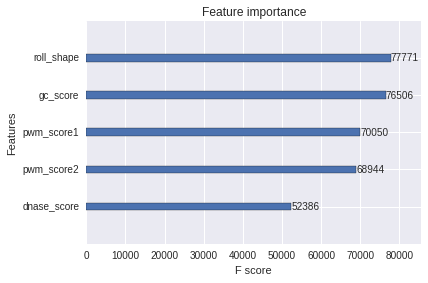

In [7]:
xgb.plot_importance(loaded_model)

### Predict on the test data

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
y_pred

In [112]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [113]:
y_test[y_test <0] = 0

In [114]:
print accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)
print classification_report(y_test, y_pred, digits=4)

0.98257723873 0.0174227612704
             precision    recall  f1-score   support

        0.0     0.9894    0.9921    0.9907    660206
        1.0     0.8751    0.8383    0.8563     43586

avg / total     0.9823    0.9826    0.9824    703792



### Take note of the following in our current model:
* The data is not scaled before training: There is no need for scaling when working with tree or ensemble models
* We are not using all the data for training due to memory constraints
* Train this and send the predictions for ranking
* Need to create a ranking code for future use

### Xgboost experiemental stuff

In [ ]:
clf = XGBClassifier()
booster = xgb.Booster()
booster.load_model('test_dump')
clf._Booster = booster
bst = xgb.XGBClassifier() #init model
final_gb.dump_model("test_dump")

### SGD

In [39]:
clf = SGDClassifier()
clf.fit(X_train, y_train)
pred_sgd = clf.predict(X_test)
print accuracy_score(y_test, pred_sgd)
print classification_report(y_test, pred_sgd, digits=4)

CPU times: user 892 ms, sys: 4 ms, total: 896 ms
Wall time: 896 ms
0.974233864551
             precision    recall  f1-score   support

       -1.0     0.9779    0.9950    0.9864    660206
        1.0     0.8969    0.6598    0.7603     43586

avg / total     0.9729    0.9742    0.9724    703792



### GradientBoosting

In [35]:
clf = GradientBoostingClassifier(loss='deviance', n_estimators=1000, max_depth=1, random_state=0)
%time clf.fit(X_train, y_train)
pred_sgd = clf.predict(X_test)
print accuracy_score(y_test, pred_sgd)
print classification_report(y_test, pred_sgd)

CPU times: user 18min 57s, sys: 22 s, total: 19min 19s
Wall time: 19min 19s
0.981225987223
             precision    recall  f1-score   support

       -1.0       0.99      0.99      0.99    660206
        1.0       0.86      0.83      0.85     43586

avg / total       0.98      0.98      0.98    703792



In [ ]:
## This can be time consuming to tune its parameters

In [ ]:
CPU times: user 1min 52s, sys: 816 ms, total: 1min 53s
Wall time: 1min 53s
0.97946410303
             precision    recall  f1-score   support

       -1.0       0.99      0.99      0.99    660206
        1.0       0.85      0.81      0.83     43586

avg / total       0.98      0.98      0.98    703792

### RandomForest

In [32]:
clf = RandomForestClassifier()
%time clf.fit(X_train, y_train)
pred_sgd = clf.predict(X_test)
print accuracy_score(y_test, pred_sgd)
print classification_report(y_test, pred_sgd)

0.979340486962
             precision    recall  f1-score   support

       -1.0       0.99      0.99      0.99    660206
        1.0       0.86      0.79      0.83     43586

avg / total       0.98      0.98      0.98    703792



### LinearSVM

In [105]:
clf = svm.LinearSVC()
clf.fit(X_train, y_train)
pred_linsvm = clf.predict(X_test)
accuracy_score(y_test, pred_linsvm)

0.96756473829201106

### SVM

In [ ]:
clf = svm.SVC()
clf.fit(X_train, y_train)
pred_svm = clf.predict(X_test)
print accuracy_score(y_test, pred_svm)
print classification_report(y_test, pred_svm)

### Optimizing parameters with grid search

At this stage it is a question of optimizing the training parameters to ensure we have an optimized model

### Selecting the most significant features

In [73]:
from sklearn import feature_selection
fs = feature_selection.SelectPercentile(
    feature_selection.chi2, percentile=100)
X_train_fs = fs.fit_transform(X_train, y_train)

In [74]:
X_test_fs = fs.fit_transform(X_test, y_test)

In [75]:
clf = SGDClassifier(loss='log', penalty="l1")
clf.fit(X_train_fs, y_train)
pred_sgd = clf.predict(X_test_fs)
print "Accuracy: %.4f" % accuracy_score(y_test, pred_sgd)
print classification_report(y_test, pred_sgd)

Accuracy: 0.9746
             precision    recall  f1-score   support

       -1.0       0.98      0.99      0.99    660206
        1.0       0.89      0.67      0.77     43586

avg / total       0.97      0.97      0.97    703792



### Testing feature importance
1. Max DNase scores
Accuracy: 0.969
             precision    recall  f1-score   support

       -1.0       0.97      0.99      0.98    330357
        1.0       0.91      0.73      0.81     32643

avg / total       0.97      0.97      0.97    363000

2. 

Optimal number of features:81 



/home/kipkurui/anaconda2/envs/dream_challenge/lib/python2.7/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


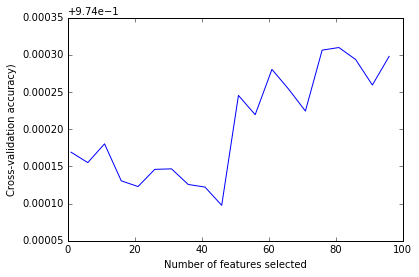

In [69]:
from sklearn import cross_validation

clf = SGDClassifier(loss='log', penalty="l1")



percentiles = range(1, 100, 5)
results = []
for i in range(1,100,5):
    
    fs = feature_selection.SelectPercentile(
        feature_selection.chi2, percentile=i
    )

    X_train_fs = fs.fit_transform(X_train, y_train)
#X_train_fs = clf.fit(X_train, y_train)

    scores = cross_validation.cross_val_score(
    clf,X_train_fs, y_train, cv=10)
    results = np.append(results, scores.mean())

optimal_percentil = np.where(results == results.max())[0]

print "Optimal number of features:{0}".format(percentiles[optimal_percentil]), "\n"


# Plot number of features VS. cross-validation scores
import pylab as pl
pl.figure()
pl.xlabel("Number of features selected")
pl.ylabel("Cross-validation accuracy)")
pl.plot(percentiles, results)

In [201]:
results

array([ 0.96878426])

# TODO

The following the next immediate steps:
- Create a single file with all the motifs required for this challenge:
    - Use best three in different clusters as input features
    - Think of how to reduce overhead here
- Convert initial data version into a bed file
    - Extract positive and negative seq
    - Combine various cell lines
    - 
- Optimize parameter selection by the models
    - Choose the best model
    - Select best parameters
- Get a better predictive model by adding more features

In [113]:
chip2name['ARID3A'.capitalize()]

'3.7.1.3.1'

In [114]:
import shutil

In [117]:
for tf in factor_names:
    tf_l = tf.capitalize()
    try:
        pwm_motif = "../../Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/Motifs/%s.meme" % chip2name[tf_l]

        tom_score = "../../Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/FisimTomtom/%s/%s.tomtom_raw.txt" % (chip2name[tf_l],chip2name[tf_l])
        if os.path.isfile(pwm_motif):
            shutil.move(pwm_motif, "../Motifs/%s.meme" % tf)
            shutil.move(tom_score, "../Motifs/%s.tomtom" % tf)
    except KeyError:
        print tf

ATF7
EP300
GABPA
MYC
REST
SPI1


These motifs will need to be extracted from the database and ranked with Tomtom:
- ATF7
- EP300
- GABPA
- MYC
- REST
- SPI1

Got all of them except for Ep300

In [39]:
def prepare_learning_data(feature_frame, pos_size, neg_size):
    """
    Given a pandas dataframe with the features,
    """
    
    #import pandas as pd
    #import numpy as np
    #from sklearn.datasets import dump_svmlight_file
    
    y = np.concatenate((np.ones(pos_size), np.ones(neg_size)*-1), axis=0)

    target = pd.Series.from_array(y)
    target = target.apply(int)
    target = target.to_frame(name="Target")
    
    target_f1 = feature_frame.T.append(target.T).T


    cutoff = target_f1.count()[0]

    ids = pd.Series.from_array(np.arange(1, cutoff+1))
    ids = ids.apply(int)

    target_f1 = target_f1.T.append(ids.to_frame(name="Id").T).T


    X = target_f1[np.setdiff1d(target_f1.columns,['Id','Target'])]
    y = target_f1.Target
    
    return target_f1

    #dump_svmlight_file(X,y,out_file,zero_based=True,multilabel=False)

In [ ]:
# feature_frame["F4"] = gomer_score
# feature_frame["F2"] = gc_score
# feature_frame["F3"] = dnase_max
# feature_frame["F4"] = dnase_mean
# feature_frame["F5"] = dnase_mean

# feature_frame.to_csv("libsvm-3.21/Arid3a/Arid3a_pwm2_gc_dnase_hepg2_100.feat", sep="\t", index_label=False, index=False)